In [1]:
from seq2seq.data.data_manager import Seq2SeqDataManager
from seq2seq.model.seq2seq_learner import Seq2seqLearner
import torch

## Initialize data

In [2]:
MIN_LENGTH = 3 #min nr of tokens in sequence so that sequence is kept (otherwse removed) 
MAX_LENGTH = 8 #max nr of tokens in sequence so that sequence is kept (otherwse removed)
MIN_COUNT = 3 #min count of tokens so that it is not transformed to <unk>

#this tokenizes, prepocesses sequences so that learner could use it
data_manager = Seq2SeqDataManager.create_from_txt('data/eng-fra_sub.txt','en', 'fr',
                                                  min_freq=MIN_COUNT, min_ntoks=MIN_LENGTH,
                                                  max_ntoks=MAX_LENGTH, switch_pair=True)

Creating training dataset
  Checking x sequence match to max, min criterias
    kept 1659 sequences from 1680 sequences
    kept 1659 sequences from 1680 sequences
  Checking y sequence match to max, min criterias
    kept 1659 sequences from 1659 sequences
    kept 1659 sequences from 1659 sequences
Creating valid dataset
  Checking x sequence match to max, min criterias
    kept 183 sequences from 184 sequences
    kept 183 sequences from 184 sequences
  Checking y sequence match to max, min criterias
    kept 183 sequences from 183 sequences
    kept 183 sequences from 183 sequences


# Initalize learner

In [3]:
hidden_size=50 #if adding pretrained wordvectors, this size must match with its size
learner=Seq2seqLearner(data_manager,hidden_size)

Encoder embedding vector didnt have 280 tokens, example ['!', 'je', 'suis', 'est', '?']
Decoder embedding vector didnt have 267 tokens, example ['i', 'it', '!', 'm', '?']


Learner is a subclass of torch nn.Module. We could see architecutre of our model:

In [4]:
learner

Seq2seqLearner(
  (encoder): EncoderRNN(
    (embedding): Embedding(280, 50, padding_idx=1)
    (gru): GRU(50, 50, num_layers=2, dropout=0.1, bidirectional=True)
  )
  (decoder): LuongAttnDecoderRNN(
    (embedding): Embedding(267, 50, padding_idx=1)
    (embedding_dropout): Dropout(p=0.1)
    (gru): GRU(50, 50, num_layers=2, dropout=0.1)
    (concat): Linear(in_features=100, out_features=50, bias=True)
    (out): Linear(in_features=50, out_features=267, bias=True)
    (attn): Attn()
  )
)

# Train model

To train a model, I created method fit, which uses our batches from dataloader to train model.

0:0:11.35 (1 50.0%) loss train: 4.355 loss valid: 3.654


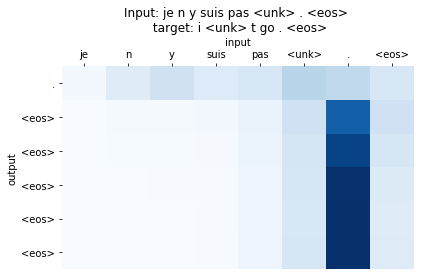

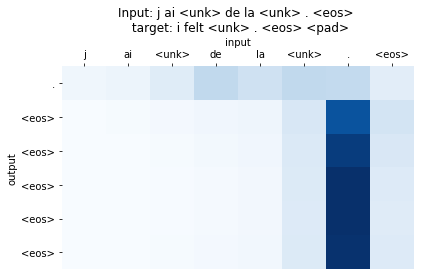

0:0:13.04 (2 100.0%) loss train: 3.19 loss valid: 3.282


In [ ]:
learner.fit(2, show_attention_every=5)

## Predict

Example  prediction:

In [ ]:
original_xtext = 'Je suis sûr.'
original_ytext = 'I am sure.'
predicted_text = learner.predict(original_xtext)
print(f'original text: {original_xtext}')
print(f'original answer: {original_ytext}')
print(f'predicted text: {predicted_text}')

original text: Je suis sûr.
original answer: I am sure.
predicted text: i i i . <eos>


## Save

Saving was supposed to be easy using nn.Module, but spacy tokenizer was having issues with pickling. So instead of torch.save(learner), we save internal state dict and data_manager separately.

In [ ]:
data_manager.save('example_data_manager.pth')
torch.save(learner.state_dict(), 'example_state_dict.pth')

## Loading 

In [ ]:
data_manager_new=Seq2SeqDataManager.load('example_data_manager.pth')

In [ ]:
#not very nice solution, but works. Learner parameters should be saved and given input for loading learner
model=Seq2seqLearner(data_manager,hidden_size) #initialize learner object
model.load_state_dict(torch.load('example_state_dict.pth')) #load state dict

In [ ]:
model

In [ ]:
#to check let's predict and see if we get same result
model.predict(original_xtext)